# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [38]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
#Defin Churn
df = df.withColumn('churn', when((df.page == 'Cancellation Confirmation') | (df.page == 'Downgrade'), 1 ).otherwise(0))

In [5]:
#Explore Data
df.show(5, truncate = False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+-----+
|Mar

In [6]:
#PringSchema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)



In [7]:
#count the missing value in the dateframe
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|churn|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|    0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+



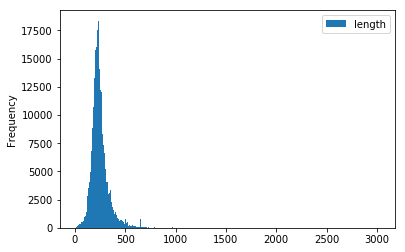

In [48]:
#numeric data visual 
df_pandas = df.select('length').toPandas()
df_pandas.plot(kind = 'hist', bins = 300)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## New numeric features

In [8]:
# number of played songs by each user
total_played_items_by_user = df.groupBy('userId').agg(countDistinct('itemInSession').alias('number_of_played_songs'))

In [9]:
total_played_items_by_user.show(5)

+------+----------------------+
|userId|number_of_played_songs|
+------+----------------------+
|100010|                   112|
|200002|                   158|
|   125|                    11|
|    51|                   613|
|   124|                   531|
+------+----------------------+
only showing top 5 rows



In [10]:
#Total played time by each user
total_played_time_by_user = df.groupBy('userId').agg(sum('length').alias('total_play_time'))

In [11]:
total_played_time_by_user.show(5)

+------+------------------+
|userId|   total_play_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [12]:
#Total number of sessions by each user
total_played_sessions_by_user = df.groupBy('userId').agg(countDistinct('sessionId').alias('number_of_sessions'))

In [13]:
total_played_sessions_by_user.show(5)

+------+------------------+
|userId|number_of_sessions|
+------+------------------+
|100010|                 7|
|200002|                 6|
|   125|                 1|
|    51|                10|
|   124|                29|
+------+------------------+
only showing top 5 rows



In [14]:
#Create user df
user_df = df.select('churn', 'userId')
user_df = user_df.dropDuplicates()

In [15]:
#Joined all these dataframes
numeric_df = user_df.join(total_played_items_by_user, ['userId'], how= 'left').\
                            join(total_played_time_by_user, ['userId'], how='left').\
                            join(total_played_sessions_by_user, ['userId'], how='left')

In [16]:
#user may have two churn values, as it might use the app first, then cancle the service. 
numeric_df.filter(numeric_df.userId == 200002).show()

+------+-----+----------------------+-----------------+------------------+
|userId|churn|number_of_played_songs|  total_play_time|number_of_sessions|
+------+-----+----------------------+-----------------+------------------+
|200002|    1|                   158|94008.87593999993|                 6|
|200002|    0|                   158|94008.87593999993|                 6|
+------+-----+----------------------+-----------------+------------------+



In [17]:
#for these users, we will only keep the cancle records. 
#order the dataframe
numeric_df = numeric_df.sort(desc('churn'))
#drop the duplicates and keep the first occurance
numeric_df = numeric_df.dropDuplicates(subset=['userId'])

In [18]:
#validate again if there are duplicates
numeric_df.filter(numeric_df.userId == 200002).show()

+------+-----+----------------------+-----------------+------------------+
|userId|churn|number_of_played_songs|  total_play_time|number_of_sessions|
+------+-----+----------------------+-----------------+------------------+
|200002|    1|                   158|94008.87593999993|                 6|
+------+-----+----------------------+-----------------+------------------+



In [19]:
# Add new colum for average play time per session
numeric_df = numeric_df.withColumn('average_play_time_per_session_by_user', numeric_df.total_play_time / numeric_df.number_of_sessions)

In [20]:
#fill na with 0
numeric_df = numeric_df.na.fill(0.0)

## Categorical Features

In [21]:
#select default categorical features
cate_df = df.select('userId', 'gender', 'level', 'location')

In [22]:
#split location into two new columns, location and country
cate_df = cate_df.withColumn('location_list', split(df['location'], ','))
cate_df = cate_df.withColumn('location', cate_df.location_list[0])
cate_df = cate_df.withColumn('country', cate_df.location_list[1]).drop('location_list')

In [23]:
#drop duplicates
cate_df = cate_df.dropDuplicates(subset=['userId']).dropna()

In [24]:
# convert all the categorical features into nurmeric

cate_feat = ['gender', 'level', 'location', 'country']

for f in cate_feat:
    stringIndexer = StringIndexer(inputCol=f, outputCol=f + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                     outputCols=[f + "classVec"])
    model = stringIndexer.fit(cate_df)
    cate_df = model.transform(cate_df)


In [25]:
#drop original categorical features
cate_df = cate_df.drop(*cate_feat)

## Final DF

In [26]:
#merge both numeric and categorical dateframe
final_df = numeric_df.join(cate_df, ['userId'], how= 'left')

In [27]:
final_df = final_df.drop('userId')
final_df = final_df.na.drop()

In [28]:
#combine all the features in one single feature vector
feature_cols = final_df.columns
feature_cols.remove('churn')
assembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
samples = assembler.transform(final_df)

In [29]:
#standard scaler the features
standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
samples = standardscaler.fit(samples).transform(samples)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [30]:
#split train/test/validation samples
train_samples, test_samples, val_samples = samples.randomSplit([0.7, 0.15,0.15], seed = 78)

### Logistic Regression

In [31]:
#Train the model with LR
model_lr = LogisticRegression(labelCol = 'churn', featuresCol = 'Scaled_features')
model_lr = model_lr.fit(train_samples)

In [32]:
#predictions
predict_train_lr = model_lr.transform(train_samples)
predict_test_lr = model_lr.transform(test_samples)

In [33]:
#Evaluating Logitical Regression

evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='churn')

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_lr)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_lr)))

The area under ROC for train set is 0.9307017543859648
The area under ROC for test set is 0.8181818181818182


### Random Forest

In [34]:
#Train the model with RF
model_rf = RandomForestClassifier(labelCol = 'churn', featuresCol = 'Scaled_features')
model_rf = model_rf.fit(train_samples)

In [35]:
#predictions
predict_train_rf = model_rf.transform(train_samples)
predict_test_rf = model_rf.transform(test_samples)

In [36]:
#Evaluating Random Forest

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))

print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

The area under ROC for train set is 0.9942982456140351
The area under ROC for test set is 0.8506493506493507


### Model selection

Based on the ROC of Logistical Regression and Random Forest on test data, choose Random Forest as the final model. 

In [37]:
#predictions on validation data
predict_val_rf = model_rf.transform(val_samples)
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_val_rf)))

The area under ROC for test set is 0.9080459770114943


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.